# Let's look at truncation of the SVD spectrum as a regularization device

In [ ]:
import os, shutil
import flopy as fp
import numpy as np
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
import pestools as pt
%matplotlib inline
# Quick check for Windows to make sure input files are Windows type
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    newln='\n'
else:
    ppp='./pestpp'
    newln='\r\n'
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

## We can work with the pilot points model, so we will copy over the pilot points files

In [16]:
base_dir = os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints')
[shutil.copy2(os.path.join(base_dir,cf),cf) for cf in os.listdir(base_dir)];
if not os.path.exists('base_pp_dir'):
    os.mkdir('base_pp_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_pp_dir',cf)) for cf in os.listdir(base_dir)];
# Since this is a sythetic example, we can load up the true K field to compare our answers to 
HK_truth = np.loadtxt(os.path.join('..','..','models','Freyberg','Freyberg_Truth','hk.truth.ref'))
# ibound can be used to mask inactive areas
ib = np.loadtxt('ibound.ref')
HK_truth[ib==0] = np.nan
forecasts_true = pd.read_csv(os.path.join('..','..','models','Freyberg','Freyberg_Truth','forecasts_true.csv'), index_col=0)

## Set up the couple functions we made for pilot points to visualize results

In [13]:
def update_K(inpstname):
    optpst = pyemu.Pst(inpstname + '.pst')
    # reset the parameter values using the best parameters from the last run
    optpst.parrep(inpstname + '.bpa')
    # set NOPTMAX=0 to run the model just a single time
    optpst.control_data.noptmax=0
    # write out the PST file with a new name
    optpst.write(inpstname + '_opt.pst')
    # run the new version of the model
    os.system('{0} {1}_opt.pst'.format(ppp, inpstname))

In [15]:
def plot_K_results(inpstname):
    HK_best = np.loadtxt('hk.ref')
    HK_best[ib==0] = np.nan
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
    im1=ax1.imshow(HK_truth, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="20%", pad=0.05)
    cbar1 = plt.colorbar(im1, cax=cax1,format="%.2f")

    im2=ax2.imshow(HK_best, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="20%", pad=0.05)
    cbar2 = plt.colorbar(im2, cax=cax2,  format="%.2f")

    im3=ax3.imshow(HK_best, interpolation='nearest', cmap='viridis')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="20%", pad=0.05)
    cbar3 = plt.colorbar(im3, cax=cax3,  format="%.2f")
    plt.tight_layout()
    plt.savefig(inpstname + 'HK_.pdf')
    
    plt.figure()
    inphi = pd.read_csv(inpstname +'.iobj')
    inphi[['total_phi','measurement_phi', 'regularization_phi']].plot()
    plt.gca().set_yscale('log')
    plt.ylabel('PHI')
    plt.xlabel('Iteration Number')

# First, let's make the Jacobian matrix at the starting conditions

In [23]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.control_data.noptmax=-1
inpst.write('freyberg_jac.pst')
shutil.copy2('freyberg_jac.pst',os.path.join('base_pp_dir','freyberg_jac.pst'))

'base_pp_dir/freyberg_jac.pst'

In [24]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_jac.pst",20,slave_root='.',port=4004,master_dir='.')

# in `pyemu` we can read in the  Jacobian and, if we form the Schur complement object, we also get $\mathbf{X}^T\mathbf{Q}\mathbf{X}$

In [27]:
injac = pyemu.Schur('freyberg_jac.jcb')

## now let's look at the singular value spectrum

In [32]:
U,S,V = np.linalg.svd(injac.xtqx.df())

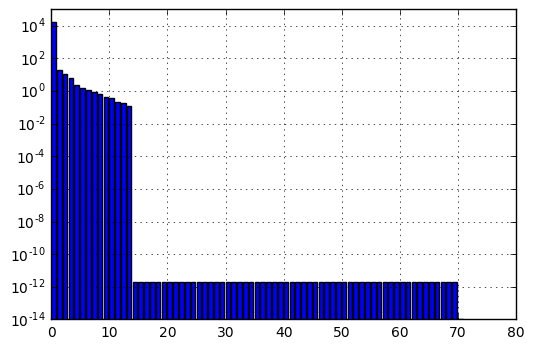

In [33]:
plt.bar(range(len(S)),S)
plt.yscale('log')
plt.grid('on')

# So what if we only use parameters comprising the first 2 singular vectors?

In [2]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')

In [ ]:
inpst.pestpp_options['n_iter_super'] = 100
inpst.pestpp_options['max_n_super'] = 2

inpst.pestpp_options

In [ ]:
inpst.write('freyberg_TSVD.pst')
shutil.copy2('freyberg_TSVD.pst',os.path.join('base_pp_dir','freyberg_TSVD.pst'))

In [10]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_TSVD.pst",20,slave_root='.',port=4004,master_dir='.')

In [11]:
indf = pd.read_csv('freyberg_TSVD.iobj')

In [ ]:
indf

In [14]:
update_K('freyberg_TSVD')

In [ ]:
plot_K_results('freyberg_TSVD')

# How does this compare with the pilot points solution with low PHIMLIM?

In [35]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.regul_lines

['   2.500000e-05       2.625000e-05     0.1000000\n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

In [18]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_pp_reg.pst",20,slave_root='.',port=4004,master_dir='.')

In [19]:
update_K('freyberg_pp_reg')

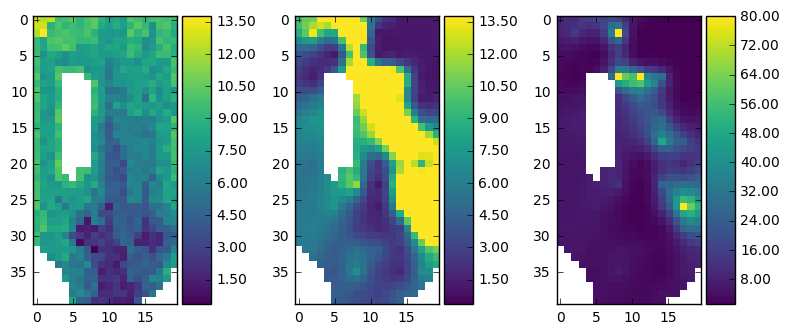

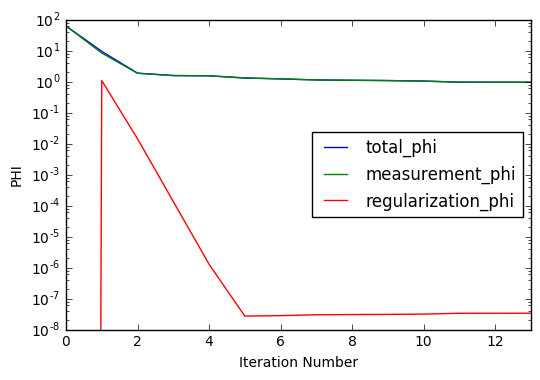

In [20]:
plot_K_results('freyberg_pp_reg')